# *Lipomyces starkeyi* medium optimization round 3. 



Medium components have a profound impact on production of microbial products. The effects of metals and vitamins on *L. starkeyi* malic acid production has been explored in a limited capacity - with the full composition space remaining to be explored. The Automated Recommendation Tool ([ART](https://www.nature.com/articles/s41467-020-18008-4)) is a machine learning based tool for bioproduction applications. The tool has been designed to provide both initial design of experiment and recommendations for further designs. The algorithm uses [Latin Hypercube Sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) to combinatorally explore the initial design space. A media optimization pipeline has been described using ART ([Zournas A et al., 2024: DOI: 10.21203/rs.3.rs-5072705/v1](https://www.researchsquare.com/article/rs-5072705/v1) that is leveraged here. 



This notebook leverages ART to identify additional explore conditions for testing during a third round of medium optimization. The notebook uses the DBTL1 and DBTL2 conditions to train a model, and uses ART to identify conditions for testing during a third round of medium optimization. 

This notebook uses two different exploit parameters during sample generation. 


## Inputs and Outputs

**Required files to run this notebook:**
- `bounds_file_R3.csv` - Contains the boundaries to explore.
- `standard_media_file.csv` - Contains the medium components.
- `combinedResults_DBTL1and2.csv` - Round 1 and 2 results.

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../')

import re
import warnings

import matplotlib.pyplot as plt
# from art.core import designs_pairwise/
from art.core import * 
import art.plot as plot
import edd_utils as eddu

import os


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/usr/local/art/.venv/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


# User parameters

In [2]:
CYCLE = 3

user_params = {
    # file containing the lower and upper bounds to explore. 
    #'bounds_file': f'mediumSetup/bounds_file.csv',
    'bounds_file': f'mediumSetup/bounds_file_DBTL3.csv',

    
    
    # folder for output files.
    'output_file_path': f'mediumConcentrationOutputs/DBTL_{CYCLE}', 
    
    
    # folder containing the standard media file. 
    # for Lipomyces - this is the LPM-40-50 (lipid production medium - 40 g carbon, 50 C/N ratio).
    'standard_media_file': f'mediumSetup/standard_media_file.csv',
    
    
}

In [3]:
user_params['components'] = [
        #'glucose',
        #'xylose',
        'KH2PO4',
        'NH4Cl',
        'KCl',
        'MgSO4*7H2O',
        'ZnSO4·7H2O',
        'H3BO3',
        'MnCl2·4H2O',
        'FeSO4·7H2O',
        'CoCl2·6H2O',
        'CuSO4·5H20',
        'Na2MoO4·2H2O',
        'Na4EDTA',
        'biotin',
        'pyridoxine',
        'thiamine',
        'riboflavin',
        'para-aminobenzoic acid',
        'nicotinic acid'
]

In [4]:
# add an response to look at malate titer percent compared to control condition.
user_params['response'] = 'Malate Titer (%)'

# Load the data

In [5]:
DBTL_results = pd.read_csv('experimentalResults/DBTL2_results/combinedResults_DBTL1and2.csv')
DBTL_results.rename(columns={'Unnamed: 0': 'Line Name'},inplace=True)

DBTL_results.tail(4)

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L)
257,22c,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,0.089010,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,0.00,0.94
258,24c,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,0.00,1.34
259,24c,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,0.00,1.20
260,24c,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.069739,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,0.01,1.40


Normalize the data via DBTL cycle to the control condition - look at percentage. 

In [6]:
# DBTL cycle 2. 
DBTL_results['Malate Titer (%)'] = DBTL_results['Malate Titer (g/L)']

mask = DBTL_results['Line Name'].str.contains("c")
columns = DBTL_results[mask]
columns

# normalize 
DBTL_results.loc[mask,'Malate Titer (%)']=(columns['Malate Titer (g/L)']/9.09333).values
columns = DBTL_results[~mask]
columns

# normalize 
DBTL_results.loc[~mask,'Malate Titer (%)']=(columns['Malate Titer (g/L)']/10.6).values
DBTL_results

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L),Malate Titer (%)
0,0a,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,...,2.022302,0.000014,0.002962,0.003923,0.029026,0.004538,0.002338,2.38,2.02,0.224528
1,0a,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,...,2.022302,0.000014,0.002962,0.003923,0.029026,0.004538,0.002338,2.43,1.52,0.229245
2,0a,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,...,2.022302,0.000014,0.002962,0.003923,0.029026,0.004538,0.002338,2.49,2.80,0.234906
3,1a,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,...,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175,0.07,0.00,0.006604
4,1a,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,...,1.973034,0.000503,0.000812,0.003438,0.000026,0.007167,0.007175,0.07,0.82,0.006604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,22c,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,0.00,1.00,0.000000
257,22c,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,0.00,0.94,0.000000
258,24c,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,0.00,1.34,0.000000
259,24c,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,0.00,1.20,0.000000


In [7]:
# add the replicate indicator (Replicate 1 = -R1, Replicate 2 = '-R2', etc) to each line name.

DBTL_results['Line Name'][0::3] = DBTL_results['Line Name'][0::3].astype(str)+'-R1'
DBTL_results['Line Name'][1::3] = DBTL_results['Line Name'][1::3].astype(str)+'-R2'
DBTL_results['Line Name'][2::3] = DBTL_results['Line Name'][2::3].astype(str)+'-R3'

/tmp/ipykernel_45572/2375468345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DBTL_results['Line Name'][0::3] = DBTL_results['Line Name'][0::3].astype(str)+'-R1'
/tmp/ipykernel_45572/2375468345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DBTL_results['Line Name'][1::3] = DBTL_results['Line Name'][1::3].astype(str)+'-R2'
/tmp/ipykernel_45572/2375468345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DBTL_results['Line 

In [8]:
DBTL_results.tail(6)

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L),Malate Titer (%)
255,22c-R1,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,0.00,0.70,0.0000
256,22c-R2,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,0.00,1.00,0.0000
257,22c-R3,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,...,2.058640,0.009972,0.009589,0.003318,0.018708,0.001813,0.006659,0.00,0.94,0.0000
258,24c-R1,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,0.00,1.34,0.0000
259,24c-R2,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,0.00,1.20,0.0000
260,24c-R3,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,...,0.913847,0.008394,0.000311,0.002309,0.044397,0.006925,0.005050,0.01,1.40,0.0011


Define the controls. In DBTL 1 and 2, controls were samples 25. 

In [9]:

# control_lines = DBTL1_results[DBTL1_results['Line Name'].str.find('25')>-1]
control_lines = DBTL_results[DBTL_results['Line Name'].str.find('25a')>-1]
control_lines

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L),Malate Titer (%)
75,25a-R1,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,...,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10.54,13.780,0.994340
76,25a-R2,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,...,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10.92,12.940,1.030189
77,25a-R3,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,...,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10.63,17.236,1.002830


How many designs imporved the response over the standard recipe?

In [10]:
control_response = np.mean(control_lines['Malate Titer (%)'])
num_improved_response = np.sum(DBTL_results['Malate Titer (%)'] > control_response)
num_designs = len(DBTL_results) - len(control_lines)
print(f'{num_improved_response} samples out of {num_designs} improve over the standard in terms of Titer ({num_improved_response/num_designs*100:.2f})%')

6 samples out of 258 improve over the standard in terms of Titer (2.33)%


## Convert the data to EDD format for ART input.

Pivot the dataframe to [Experimental Data Depot format](https://edd-docs.jbei.org/), inlcuding all components names and protocols:

In [11]:
DBTL_stacked = DBTL_results.set_index('Line Name').stack().reset_index()
DBTL_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
DBTL_stacked.head()

,Line Name,Measurement Type,Value
0,0a-R1,KH2PO4,3.980770
1,0a-R1,NH4Cl,2.726696
2,0a-R1,KCl,3.101909
3,0a-R1,MgSO4*7H2O,3.564820
4,0a-R1,ZnSO4·7H2O,0.342065


In [12]:
# DBTL_stacked.csv('DBTL1&2EDDformatedResults.csv')

# Media designs recommendations

## ART parameter setup

Define a dictionary that contains the settings ART will use to find the recommended designs:


In [13]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds_file': user_params['bounds_file'], # file with bounds for input variables (i.e., features)
    'seed': 12,
    'cross_val': True,
    'recommend': False,
    'output_directory': user_params['output_file_path'],
    'verbose': 0,
    'max_mcmc_cores':4
}

We will first run only the model building part and then proceed with optimization using the two modes - exploration and explotation.

In [14]:
user_params['alpha_explor'] = 1.0
user_params['alpha_exploit'] = None
# user_params['objective'] = 'maximize'                                     # Type of the objective

In [15]:
# user_params['threshold'] = 0.5 # percent improvement to be considered a success.



Here we specify how many instances (design) we want to create and how many replicates:

In [16]:
user_params['n_instances_explore'] = 15
user_params['n_instances_exploit'] = 4 # at rel_low distance
user_params['n_instances_exploit_large_rel_dist'] = 6 # at rel_low distance

user_params['n_replicates'] = 3

with the configuration now stored in art_params, we now run ART:

## Initialize and Train ART

In [17]:
run_art = True

Dataframe does not have a time column matching one of the supported formats. Assuming that all data in the file comes from a single time point.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.
The number of effective samples is smaller than 10% for some parameters.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 12 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sa

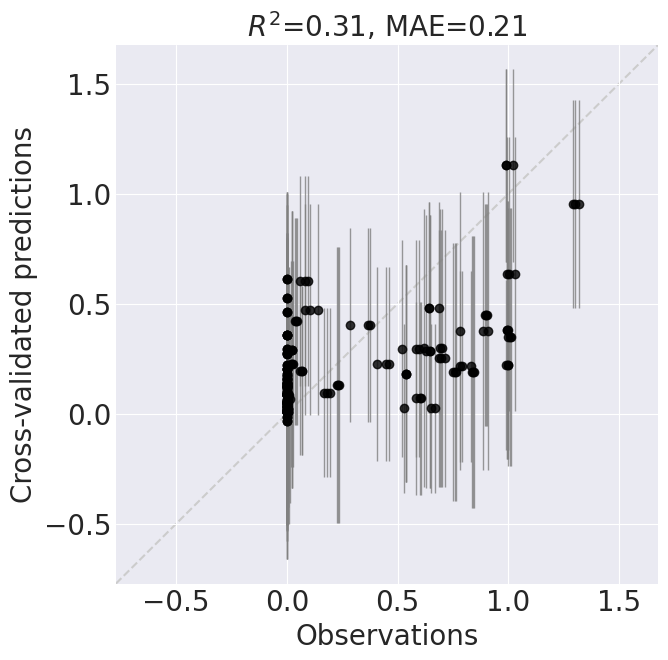

Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 24 seconds.
The number of effective samples is smaller than 10% for some parameters.


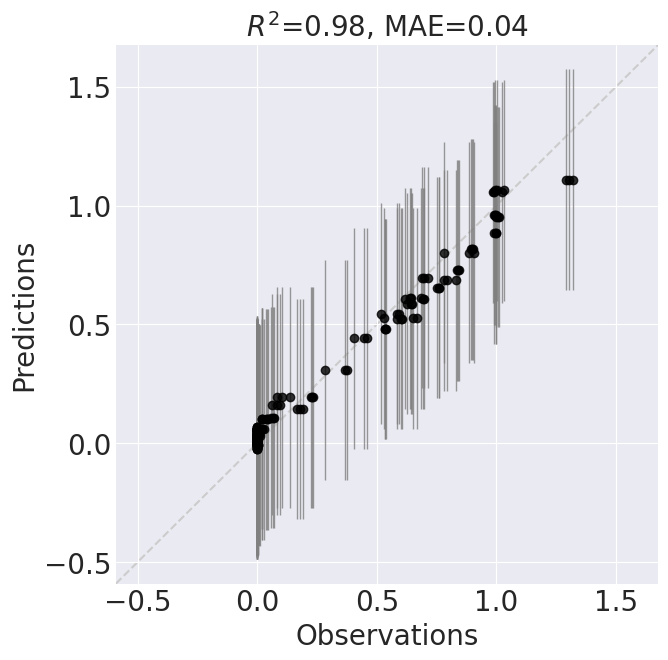

CPU times: user 23min 12s, sys: 8.6 s, total: 23min 21s
Wall time: 26min 26s


In [18]:
%%time
warnings.filterwarnings("ignore")
if run_art:
    art = RecommendationEngine(DBTL_stacked, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

In [19]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.290165,inf,0.253970,0.148696,-0.242303
Random Forest Regressor,0.192260,NaN,0.204677,0.078857,0.341183
Support Vector Regressor,0.209113,inf,0.166455,0.071435,0.403183
Kernel Ridge Regressor,0.182096,inf,0.199612,0.073004,0.390079
K-NN Regressor,0.211360,NaN,0.249176,0.106762,0.108043
Gaussian Process Regressor,0.258962,inf,0.169550,0.095809,0.199555
Gradient Boosting Regressor,0.198220,inf,0.229801,0.092099,0.230544
TPOT Regressor,0.215854,NaN,0.239369,0.103890,0.132035
Ensemble Model,0.209787,inf,0.195545,0.082248,0.312845


## Exploitation recommendations #1. 

In [22]:
%%time
art.niter = 100000
art.alpha = user_params['alpha_exploit']
draws = art.parallel_tempering_opt()

CPU times: user 198 ms, sys: 27.2 ms, total: 225 ms
Wall time: 5min 46s


In [23]:
orig_file_name = f"{art_params['output_directory']}/draws.txt"
new_file_name = f"{art_params['output_directory']}/draws_exploit.txt"
os.rename(orig_file_name, new_file_name)

code to reload draws if interupted. 

In [24]:
# file_path = f"{art_params['output_directory']}/draws_exploit.txt"
# draws = np.loadtxt(file_path)
# draws = draws[:,:-2]

In [25]:
art.num_recommendations = user_params['n_instances_exploit'] # # instances explointing in DBTL2
art.rel_rec_distance = 0.2 # Default is 0.2

# At least one of the features in the recommendation must differ by this relative factor from any point in the training data and any previous recommendations
# Then pick the one with the best objective function value and add to the recommendations. Repeat the distance filtering above. 

# If it cannot find enough recommendations, it will decrease the distance by 0.80x and try again.
art.recommend(draws)

In [26]:
df_rec_exploit = art.recommendations.copy()

Add standard deviation for the predictions:

In [27]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_exploit.values[:, :-1]
        ) # posterior predictive statistics: mean and std

df_rec_exploit['Malate Titer (g/L) mean'] = predicted_mean
df_rec_exploit['Malate Titer (g/L) std'] = predicted_std

df_rec_exploit['Label'] = 'exploitation' # will be used for plotting in the parity plot in notebook F


In [28]:
df_rec_exploit

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (%),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,1.823670,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
1,2.738248,1.284099,0.860273,1.528955,0.275753,0.101989,0.312674,0.187852,0.458098,0.251518,...,0.003084,0.003881,0.007919,0.005949,0.007533,0.007714,0.602584,0.602584,0.241066,exploitation
2,2.631820,1.069462,0.820505,0.458457,0.155002,0.174604,0.203008,0.255577,0.379339,0.078182,...,0.003879,0.003764,0.003826,0.005992,0.004998,0.006287,0.595918,0.595918,0.239930,exploitation
3,1.601206,0.934964,0.126140,2.760471,0.115067,0.237814,0.462673,0.097420,0.122349,0.300567,...,0.006886,0.004630,0.007549,0.003106,0.006238,0.005901,0.592427,0.592427,0.239979,exploitation


In [29]:
def designs_pairwise(art, df):

    dim = art.num_input_var

    plt.style.use(["seaborn-talk"])

    fig = plt.figure(figsize=(50, 50))
    fig.patch.set_facecolor("white")

    X = df.values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="r",
                edgecolor="r",
                marker=".",
                s=100,
                lw=1,
                label="Train data",
            )
            # print(var1)
            # print(var2)
            # ax.scatter(
            #     standard[var1],
            #     standard[var2],
            #     c="k",
            #     marker=".",
            #     s=126,
            #     lw=1,
            #     label="Standard",
            # )
            
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(f'{art.outDir}/l.png', transparent=False, dpi=300)

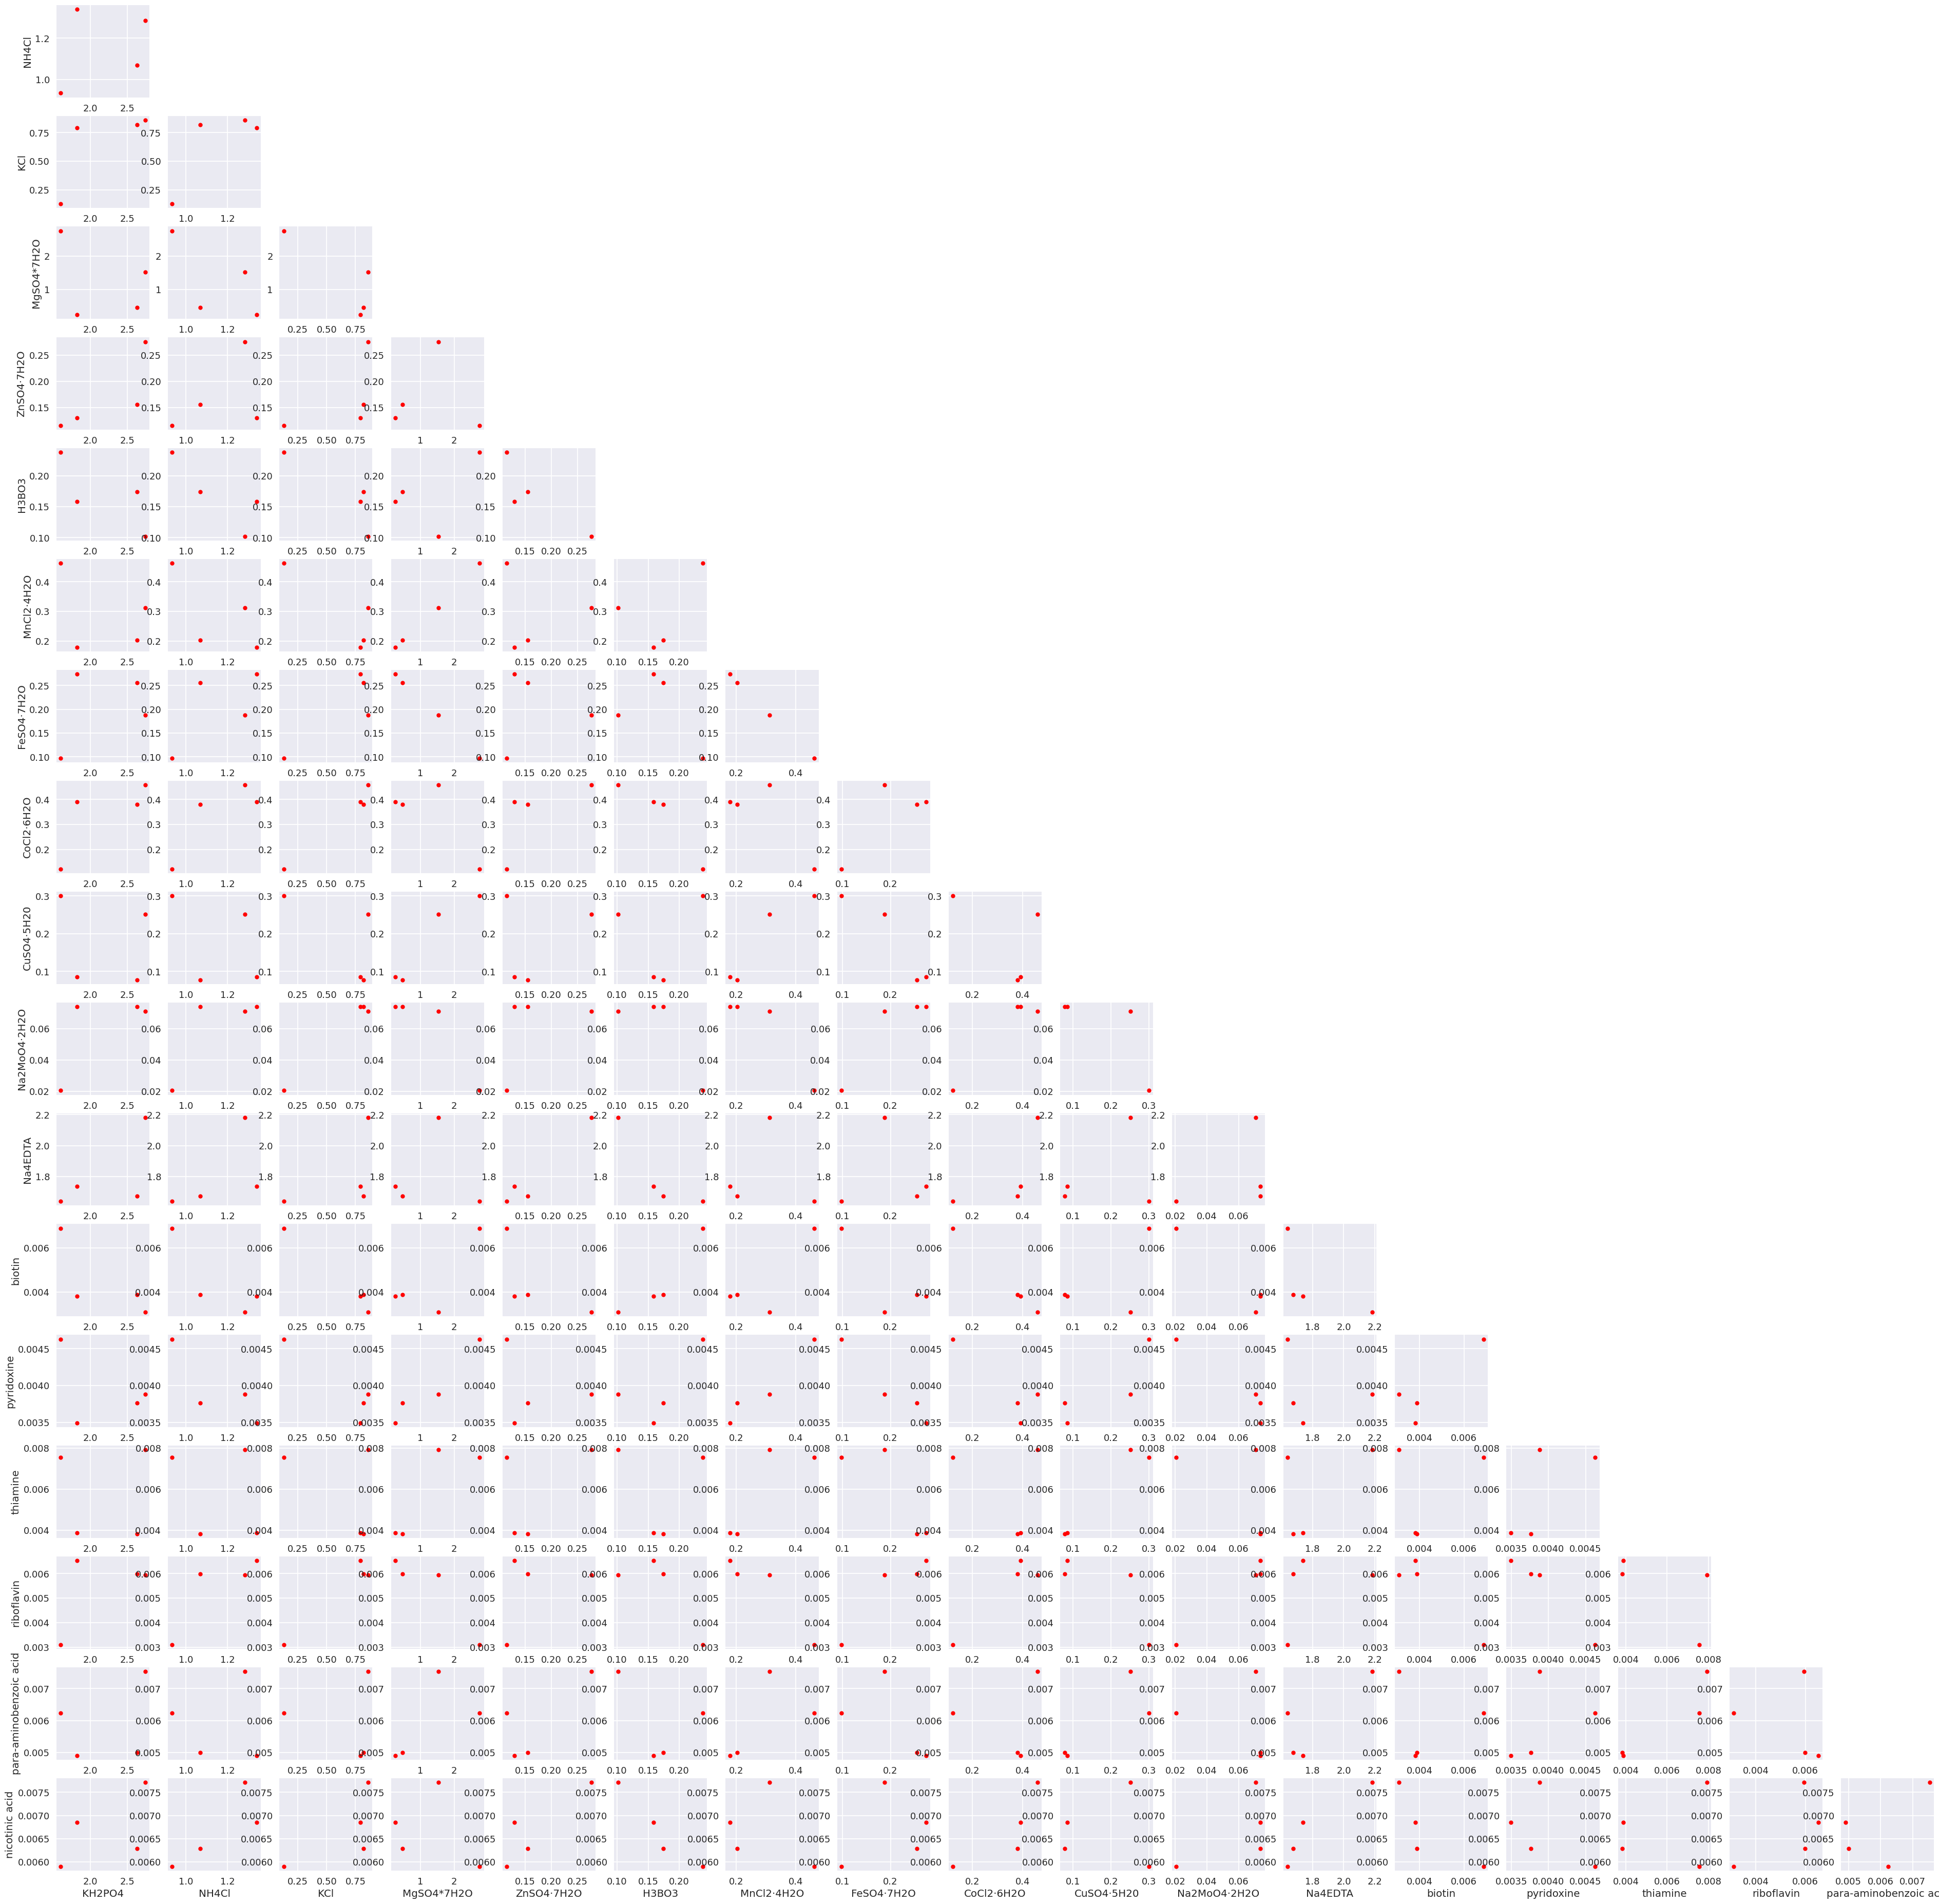

In [30]:
designs_pairwise(art, df_rec_exploit)

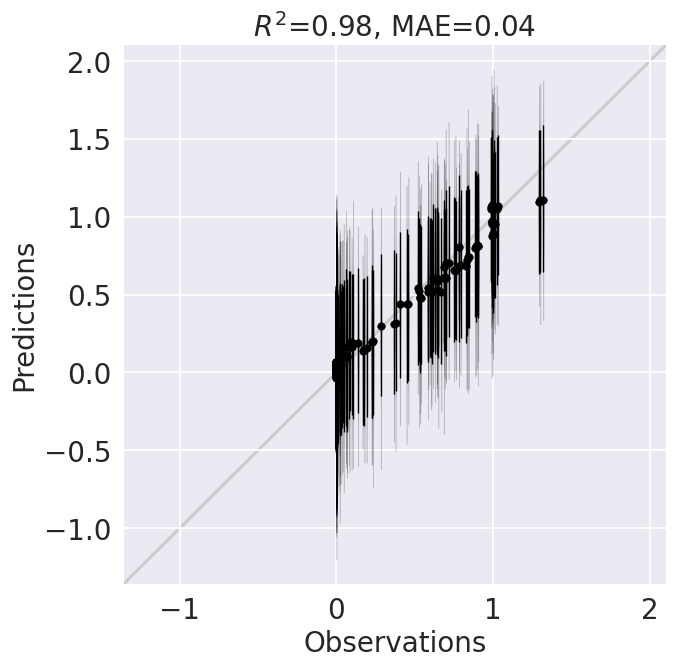

(None,)

In [31]:
plot.predictions_distr_vs_observations(art, cv_flag=False, widths=0.01),
                                       # xlim=[[-50, 200]], ylim=[[-100, 250]])

## Exploitation recommendations #2.

Exploit with the largest Rel_distance possible. 

add the previously collected exploit samples to minimize overlap duirng art sampling. 

In [32]:

original_training_data = art.df["Input Variables"]
art.df['Input Variables'].append(df_rec_exploit)

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (%),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0a-R1,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.000014,0.002962,0.003923,0.029026,0.004538,0.002338,NaN,NaN,NaN,NaN
0a-R2,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.000014,0.002962,0.003923,0.029026,0.004538,0.002338,NaN,NaN,NaN,NaN
0a-R3,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.000014,0.002962,0.003923,0.029026,0.004538,0.002338,NaN,NaN,NaN,NaN
0b-R1,4.087562,2.131518,2.837720,2.355412,0.425586,1.040215,0.005711,0.002432,0.134524,0.388366,...,0.007791,0.000308,0.004017,0.001244,0.000074,0.000081,NaN,NaN,NaN,NaN
0b-R2,4.087562,2.131518,2.837720,2.355412,0.425586,1.040215,0.005711,0.002432,0.134524,0.388366,...,0.007791,0.000308,0.004017,0.001244,0.000074,0.000081,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9c-R3,1.453368,1.392585,0.505966,0.591378,0.436441,0.388113,0.388718,0.251436,0.247073,0.071365,...,0.006881,0.000177,0.002322,0.029524,0.009554,0.008719,NaN,NaN,NaN,NaN
0,1.823670,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
1,2.738248,1.284099,0.860273,1.528955,0.275753,0.101989,0.312674,0.187852,0.458098,0.251518,...,0.003084,0.003881,0.007919,0.005949,0.007533,0.007714,0.602584,0.602584,0.241066,exploitation
2,2.631820,1.069462,0.820505,0.458457,0.155002,0.174604,0.203008,0.255577,0.379339,0.078182,...,0.003879,0.003764,0.003826,0.005992,0.004998,0.006287,0.595918,0.595918,0.239930,exploitation


In [33]:
# At least one of the features in the recommendation must differ by this relative factor from any point in the training data and any previous recommendations
# Then pick the one with the best objective function value and add to the recommendations. Repeat the distance filtering above. 

art.num_recommendations = user_params['n_instances_exploit_large_rel_dist'] # # instances exploiting in DBTL2
art.rel_rec_distance = 10# Default is 0.2

In [34]:

# If it cannot find enough recommendations, it will decrease the distance by 0.80x and try again.
art.recommend(draws)

In [35]:
art.df['Input Variables'] = original_training_data 

In [36]:
df_rec_exploit_2 = art.recommendations.copy()

In [37]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_exploit_2.values[:, :-1]
        ) # posterior predictive statistics: mean and std

df_rec_exploit_2['Malate Titer (g/L) mean'] = predicted_mean
df_rec_exploit_2['Malate Titer (g/L) std'] = predicted_std

df_rec_exploit_2['Label'] = 'exploitation' # will be used for plotting in the parity plot in notebook F


In [38]:
df_rec_exploit_all = df_rec_exploit.append(df_rec_exploit_2)


## Exploration recommendations

In [39]:


%%time
art.niter = 100000
art.alpha = user_params['alpha_explor']
draws = art.parallel_tempering_opt()



CPU times: user 172 ms, sys: 19.1 ms, total: 191 ms
Wall time: 5min 46s


In [40]:


orig_file_name = f"{art_params['output_directory']}/draws.txt"
new_file_name = f"{art_params['output_directory']}/draws_explor.txt"
os.rename(orig_file_name, new_file_name)



In [41]:
art.num_recommendations = user_params['n_instances_explore']
art.rel_rec_distance = 5.0
art.recommend(draws)


In [42]:
df_rec_explor = art.recommendations.copy()

In [43]:
df_rec_explor

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (%)
0,2.675450,0.718840,3.881238,3.636742,0.352726,0.051098,0.129892,0.033320,0.354811,0.493949,0.007218,2.262191,0.008654,0.001708,0.008913,0.006837,0.009223,0.009281,0.258303
1,1.021826,1.564132,3.096819,3.274302,0.181124,0.090980,0.001726,0.088025,0.335029,0.487033,0.006408,2.042985,0.007478,0.008431,0.007543,0.002260,0.008886,0.009076,0.275814
2,2.052376,1.302430,1.038093,3.241529,0.365306,0.343563,0.442676,0.322074,0.439938,0.109627,0.047584,2.102422,0.001807,0.002872,0.008385,0.003227,0.004253,0.009967,0.343078
3,3.835088,1.442873,2.799600,1.416631,0.433142,0.270771,0.402906,0.227753,0.211955,0.112671,0.040598,2.151518,0.007857,0.004738,0.000729,0.003933,0.009583,0.008930,0.396501
4,4.827633,1.561360,4.731278,4.488811,0.470204,0.034155,0.213302,0.065942,0.329168,0.334003,0.056979,2.194828,0.006021,0.006394,0.004050,0.006432,0.008118,0.008818,0.233174
5,4.924544,0.688786,2.975392,2.406930,0.483582,0.076205,0.459237,0.343207,0.228827,0.464075,0.062698,2.305250,0.000999,0.007211,0.006604,0.003688,0.008545,0.008830,0.227865
6,2.110262,2.823822,2.594190,3.194156,0.214776,0.271540,0.117443,0.076750,0.394923,0.094772,0.039058,1.547659,0.007760,0.001625,0.003157,0.000909,0.008038,0.008937,0.270473
7,1.637061,1.495329,3.684340,2.821618,0.086569,0.356574,0.430721,0.069442,0.063083,0.130807,0.008309,1.577210,0.008587,0.007352,0.003352,0.006147,0.009890,0.007809,0.343151
8,1.868793,1.140132,1.183767,4.376377,0.094458,0.446525,0.432871,0.083258,0.341080,0.468879,0.023241,1.817038,0.007784,0.003041,0.007824,0.005509,0.002498,0.009927,0.219507
9,0.615327,2.326264,1.506348,0.865033,0.272463,0.399174,0.162566,0.430167,0.475969,0.283335,0.099332,2.370399,0.009214,0.009490,0.009306,0.006107,0.006884,0.007198,0.260824


In [44]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_explor.values[:, :-1]
        )
df_rec_explor['Malate Titer (g/L) mean'] = predicted_mean
df_rec_explor['Malate Titer (g/L) std'] = predicted_std

df_rec_explor['Label'] = 'exploration'

In [45]:
df_rec_explor

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (%),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,2.675450,0.718840,3.881238,3.636742,0.352726,0.051098,0.129892,0.033320,0.354811,0.493949,...,0.008654,0.001708,0.008913,0.006837,0.009223,0.009281,0.258303,0.258303,0.244882,exploration
1,1.021826,1.564132,3.096819,3.274302,0.181124,0.090980,0.001726,0.088025,0.335029,0.487033,...,0.007478,0.008431,0.007543,0.002260,0.008886,0.009076,0.275814,0.275814,0.243203,exploration
2,2.052376,1.302430,1.038093,3.241529,0.365306,0.343563,0.442676,0.322074,0.439938,0.109627,...,0.001807,0.002872,0.008385,0.003227,0.004253,0.009967,0.343078,0.343078,0.243007,exploration
3,3.835088,1.442873,2.799600,1.416631,0.433142,0.270771,0.402906,0.227753,0.211955,0.112671,...,0.007857,0.004738,0.000729,0.003933,0.009583,0.008930,0.396501,0.396501,0.242080,exploration
4,4.827633,1.561360,4.731278,4.488811,0.470204,0.034155,0.213302,0.065942,0.329168,0.334003,...,0.006021,0.006394,0.004050,0.006432,0.008118,0.008818,0.233174,0.233174,0.241663,exploration
5,4.924544,0.688786,2.975392,2.406930,0.483582,0.076205,0.459237,0.343207,0.228827,0.464075,...,0.000999,0.007211,0.006604,0.003688,0.008545,0.008830,0.227865,0.227865,0.241653,exploration
6,2.110262,2.823822,2.594190,3.194156,0.214776,0.271540,0.117443,0.076750,0.394923,0.094772,...,0.007760,0.001625,0.003157,0.000909,0.008038,0.008937,0.270473,0.270473,0.241323,exploration
7,1.637061,1.495329,3.684340,2.821618,0.086569,0.356574,0.430721,0.069442,0.063083,0.130807,...,0.008587,0.007352,0.003352,0.006147,0.009890,0.007809,0.343151,0.343151,0.241218,exploration
8,1.868793,1.140132,1.183767,4.376377,0.094458,0.446525,0.432871,0.083258,0.341080,0.468879,...,0.007784,0.003041,0.007824,0.005509,0.002498,0.009927,0.219507,0.219507,0.241080,exploration
9,0.615327,2.326264,1.506348,0.865033,0.272463,0.399174,0.162566,0.430167,0.475969,0.283335,...,0.009214,0.009490,0.009306,0.006107,0.006884,0.007198,0.260824,0.260824,0.240971,exploration


In [51]:


def designs_pairwise(art, df):

    dim = art.num_input_var

    plt.style.use(["seaborn-talk"])

    fig = plt.figure(figsize=(50, 50))
    fig.patch.set_facecolor("white")

    X = df.values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            # ax.scatter(
            #     X[:, var1],
            #     X[:, var2],
            #     c="r",
            #     edgecolor="r",
            #     marker=".",
            #     # s0a-R1=150,
            #     s=150
            #     lw=1,
            #     label="Train data",
            # )
            ax.scatter(
                X[:, var1],            # Data for x-axis
                X[:, var2],            # Data for y-axis
                c="r",                 # Color of the markers
                marker=".",            # Shape of the markers
                s=150,                 # Size of the markers
                lw=1,                  # Line width of marker edges
                label="Train data",    # Label for the legend
            )
            
            # print(var1)
            # print(var2)
            # ax.scatter(
            #     standard[var1],
            #     standard[var2],
            #     c="k",
            #     marker=".",
            #     s=126,
            #     lw=1,
            #     label="Standard",
            # )
            
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(f'{art.outDir}/l.png', transparent=False, dpi=300)



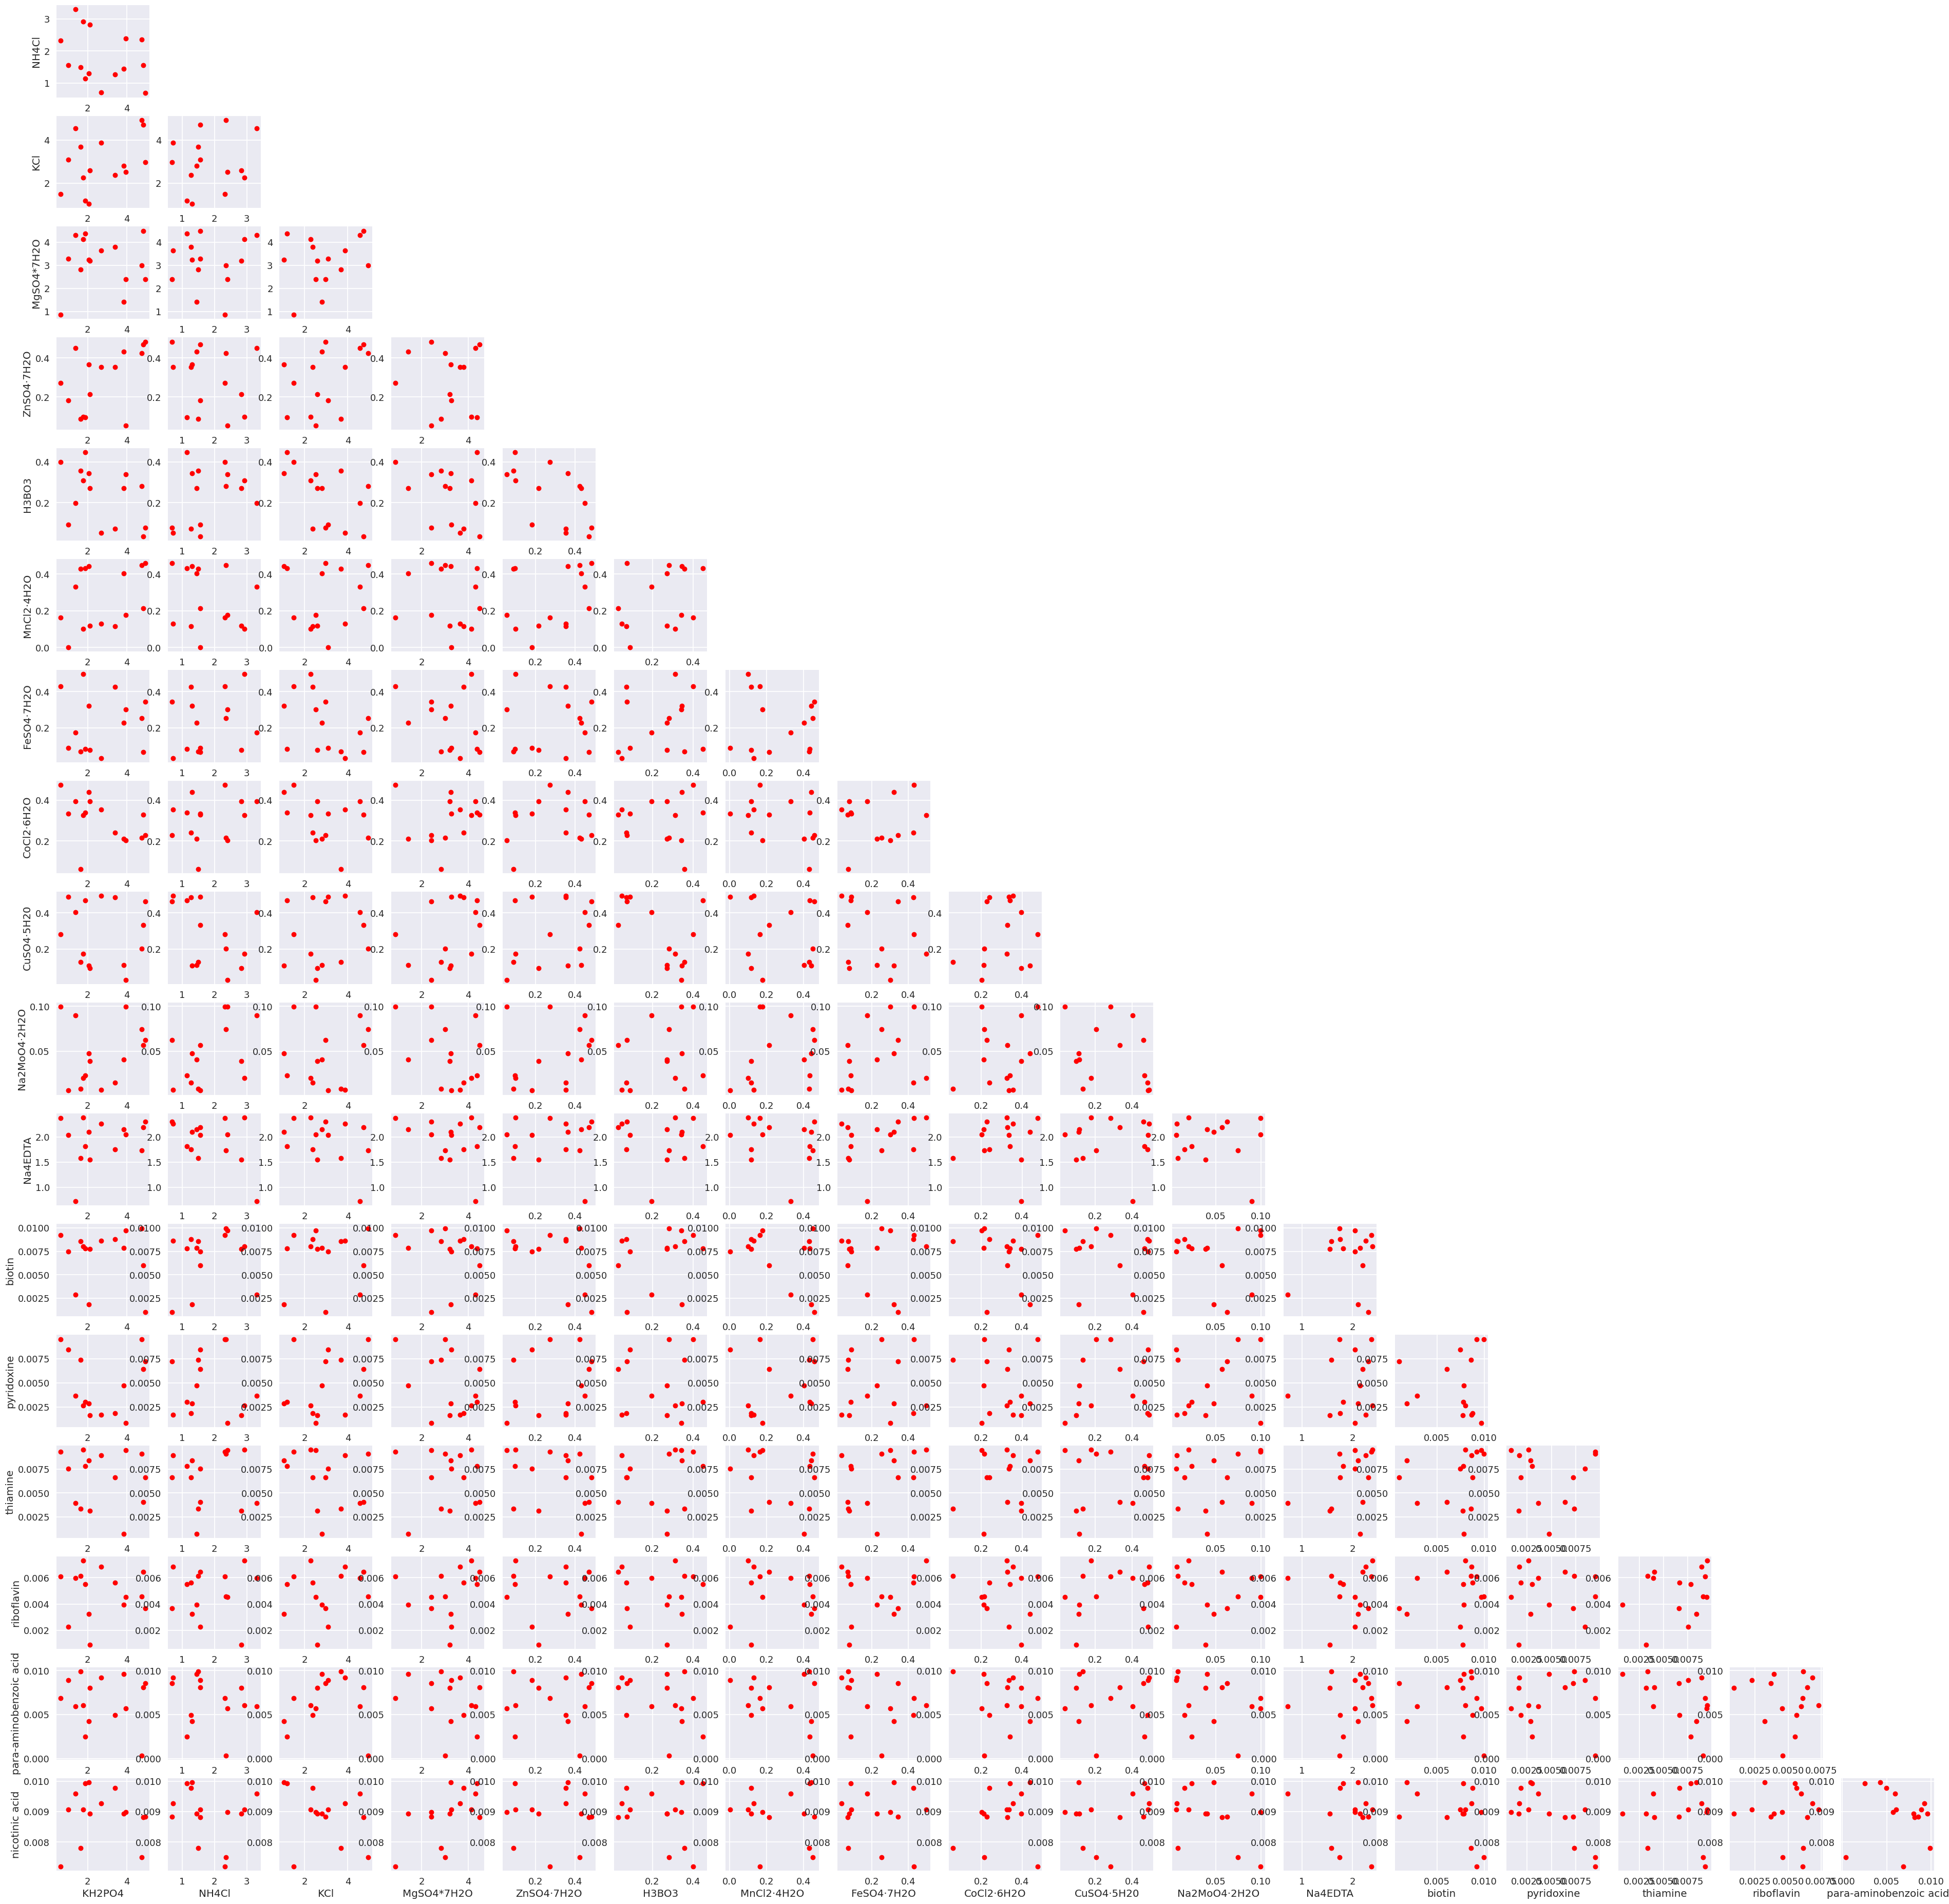

In [52]:
designs_pairwise(art, df_rec_explor)

In [53]:
df_rec = df_rec_exploit_all.append(df_rec_explor)

In [54]:
# df_rec = df_rec.rename(columns={"Malate titer (g/L)": "Malate titer (g/L) prediction"})

# Generate the control media

Read the standard recipe:

In [55]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Ingrediant")



Control media will be uniformly drawn from the interval 
90% to 110% around the standard recipe.


In [56]:


ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Standard concentration (LPM-40-50)']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control



,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid
Control,1.401804,1.37094,0.508727,0.475226,0.002299,0.011808,0.004561,0.005097,0.001738,0.001756,0.000085,0.005352,0.000108,0.000093,0.000095,0.000108,0.000109,0.000107




Check that these controls are not equivalent to the controls tested in previous cycles:


In [57]:
for component in user_params['components']:
     assert(all(df_control.at['Control', component] != control_lines[component]))


Add ART's prediction for this design


In [58]:


control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )


df_control['Malate Titer (g/L) mean'] = control_predicted_mean
df_control['Malate Titer (g/L) std'] = control_predicted_std
df_control['Label'] = 'standard'



In [59]:
df_rec = df_rec.append(df_control).reset_index(drop=True)
df_rec

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (%),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,1.82367,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
1,2.738248,1.284099,0.860273,1.528955,0.275753,0.101989,0.312674,0.187852,0.458098,0.251518,...,0.003084,0.003881,0.007919,0.005949,0.007533,0.007714,0.602584,0.602584,0.241066,exploitation
2,2.63182,1.069462,0.820505,0.458457,0.155002,0.174604,0.203008,0.255577,0.379339,0.078182,...,0.003879,0.003764,0.003826,0.005992,0.004998,0.006287,0.595918,0.595918,0.239930,exploitation
3,1.601206,0.934964,0.12614,2.760471,0.115067,0.237814,0.462673,0.09742,0.122349,0.300567,...,0.006886,0.00463,0.007549,0.003106,0.006238,0.005901,0.592427,0.592427,0.239979,exploitation
4,1.612011,1.323856,0.242405,4.147066,0.03397,0.112,0.191472,0.301372,0.287936,0.218239,...,0.007021,0.00611,0.00217,0.007353,0.005734,0.00613,0.533017,0.533017,0.239322,exploitation
5,4.19672,1.461668,2.594845,1.692926,0.083325,0.091454,0.408242,0.250229,0.342213,0.106064,...,0.007193,0.006335,0.002926,0.007422,0.003771,0.009951,0.526519,0.526519,0.240645,exploitation
6,2.148154,2.720261,4.529747,0.448976,0.381521,0.034277,0.18323,0.32469,0.097828,0.129063,...,0.008927,0.001679,0.003107,0.007414,0.008987,0.005651,0.433369,0.433369,0.239502,exploitation
7,1.419173,3.038508,0.264294,4.016113,0.411739,0.084393,0.438187,0.418037,0.33458,0.104072,...,0.007804,0.007313,0.009914,0.003982,0.001454,0.007099,0.409223,0.409223,0.242281,exploitation
8,2.546857,1.882733,2.20075,3.467932,0.370727,0.135899,0.092613,0.309052,0.344832,0.093774,...,0.005636,0.008028,0.008808,0.006692,0.005526,0.007138,0.397457,0.397457,0.239780,exploitation
9,0.429504,0.572796,4.446868,2.269822,0.392297,0.008179,0.484359,0.373143,0.418843,0.049938,...,0.001815,0.009191,0.008835,0.000142,0.006977,0.00623,0.336897,0.336897,0.239955,exploitation


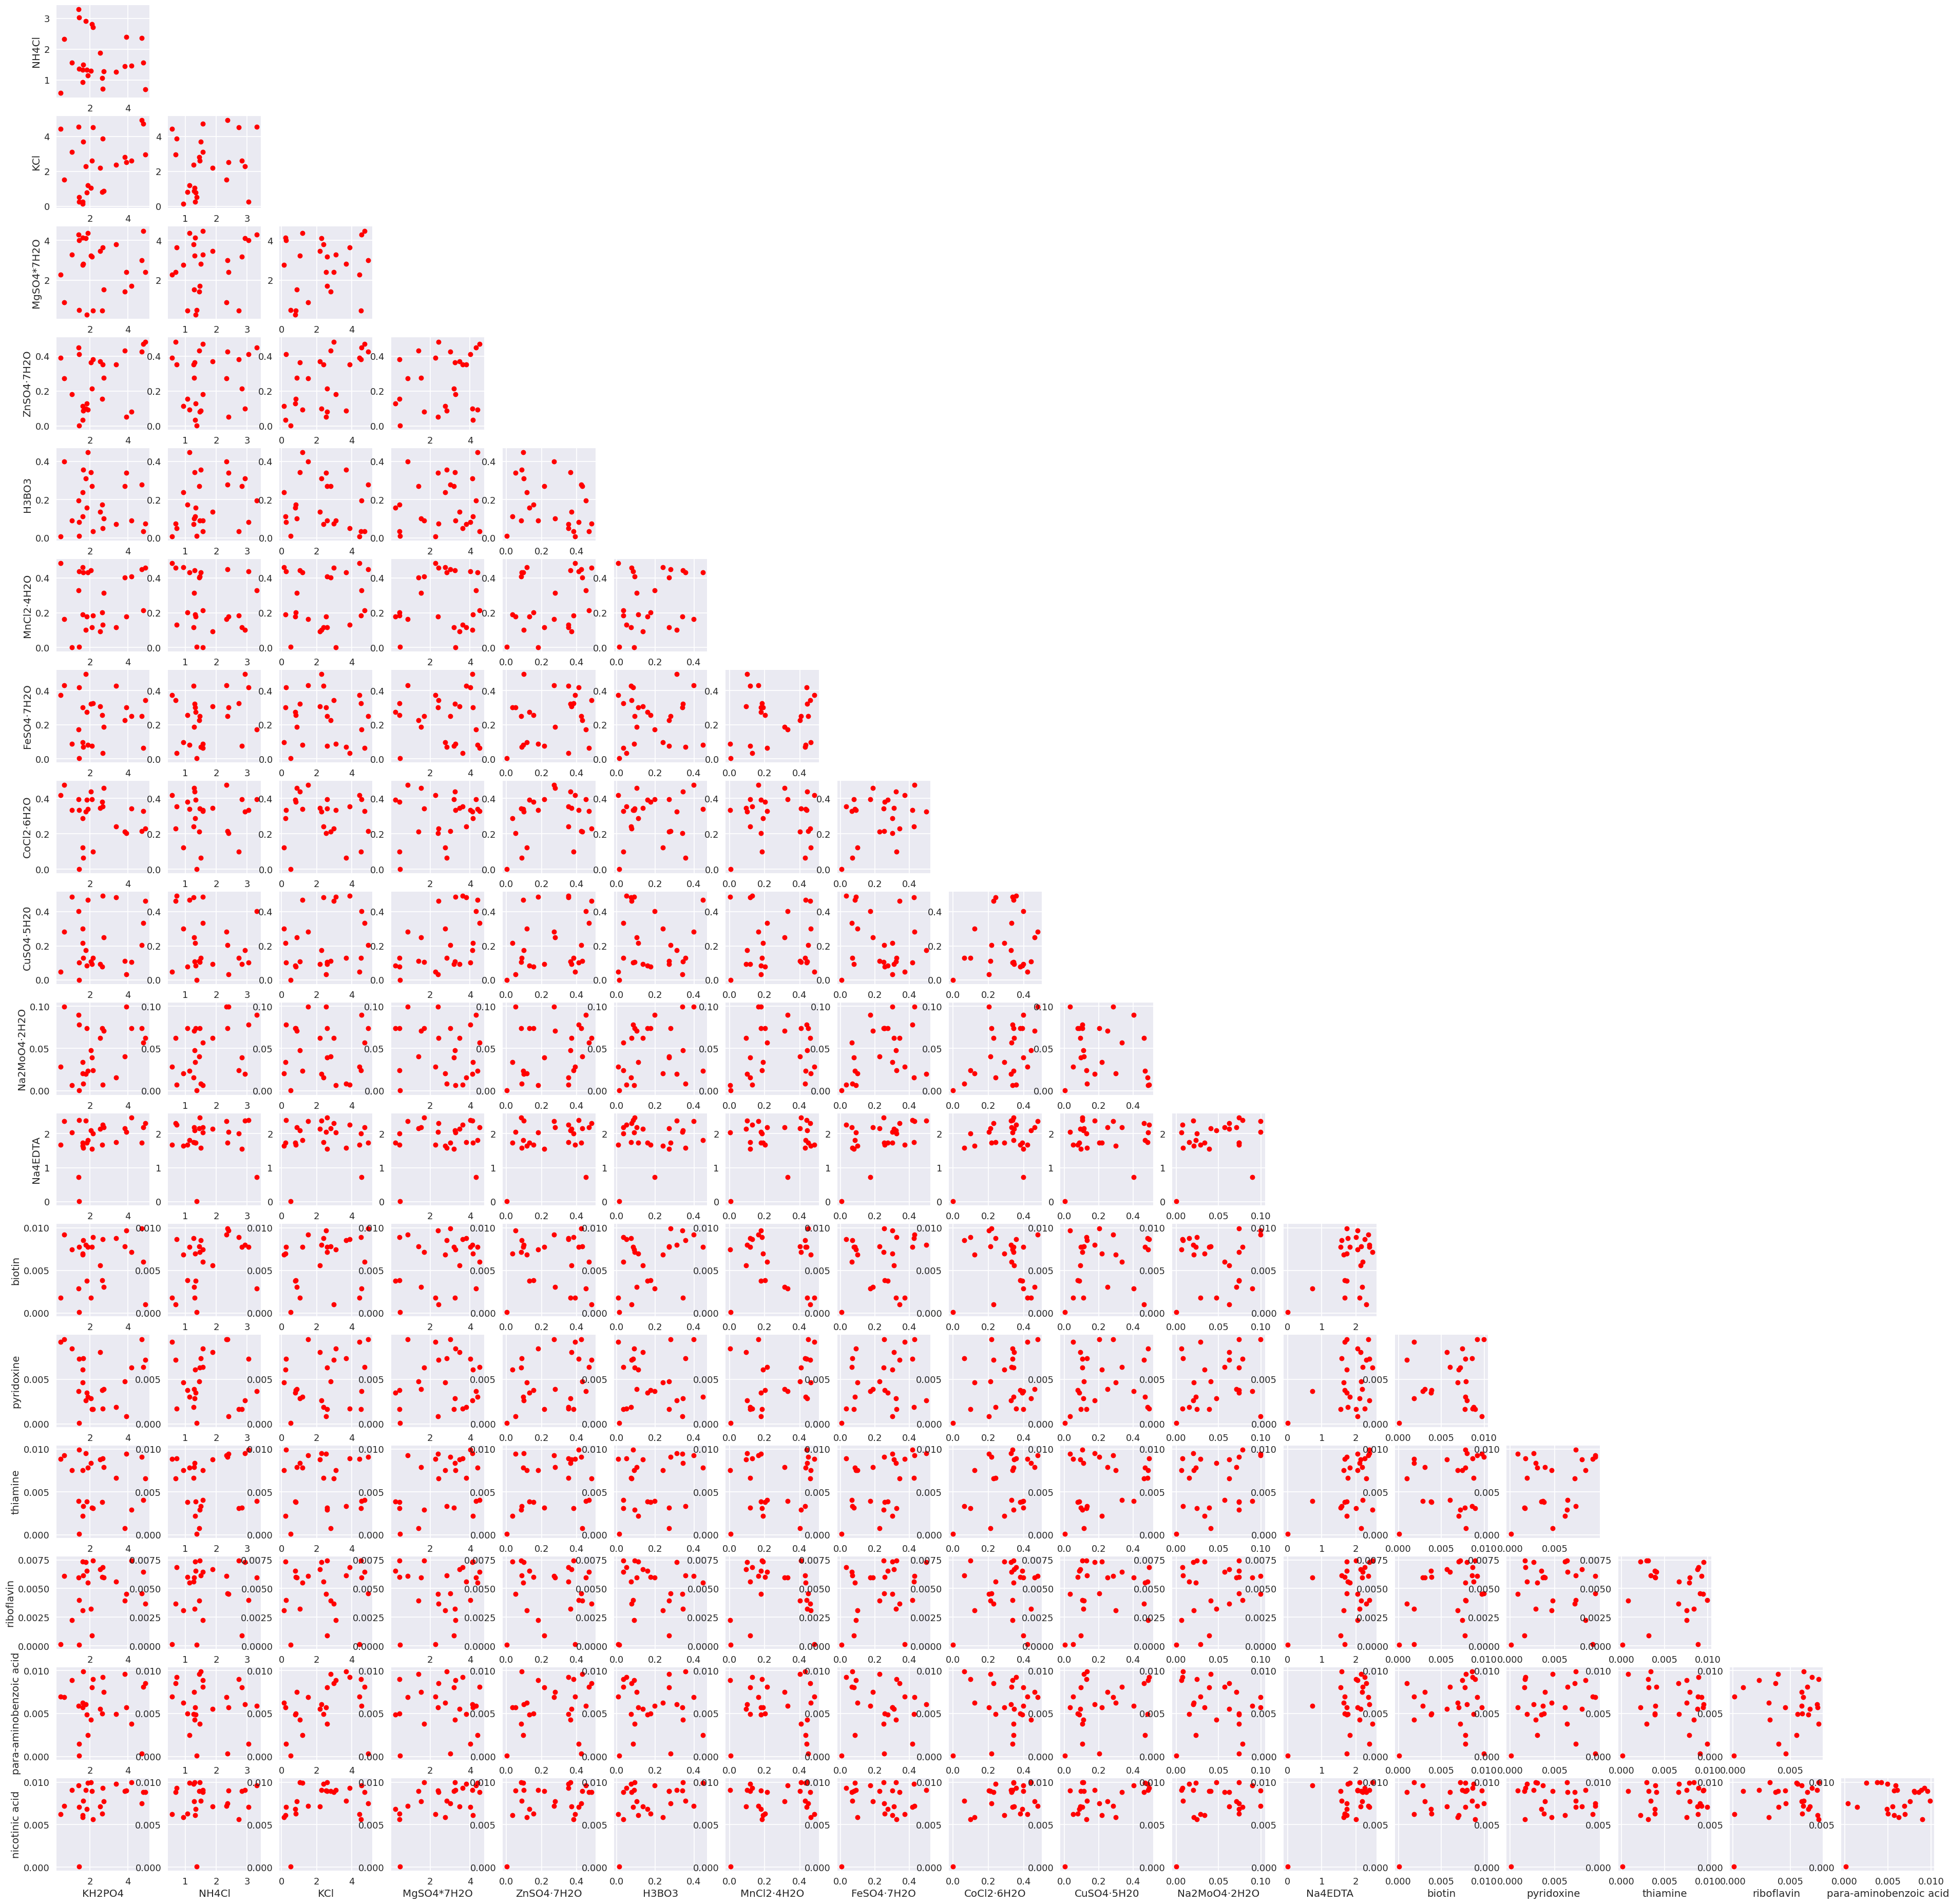

In [60]:
designs_pairwise(art, df_rec)


## Check the distribution of designs

Define dataframe with train data and predictions:


In [61]:
df_train = DBTL_results[user_params['components']]
df_train['Malate Titer (g/L)'] = DBTL_results['Malate Titer (g/L)']



Add predictions, cv-predictions and standard deviation of the OD340 predictions:


In [62]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )


In [63]:
df_train['Malate_pred'] = train_predicted_mean
df_train['Malate_std'] = train_predicted_std
df_train['Malate_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['Malate_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]

Add label for control lines:

In [64]:

df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Ingrediant")
df_train['Label'] = 'train'
# df_train.loc[control_lines.index, 'Label'] = 'standard'



In [65]:
# df_stand

In [66]:
# df_train[df_train['Label']=='standard'].


In [67]:
df_train

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate_pred,Malate_std,Malate_cv_pred,Malate_cv_std,Label
0,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.003923,0.029026,0.004538,0.002338,2.38,0.193739,0.236992,0.129858,0.319206,train
1,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.003923,0.029026,0.004538,0.002338,2.43,0.193739,0.236992,0.129858,0.319206,train
2,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.003923,0.029026,0.004538,0.002338,2.49,0.193739,0.236992,0.129858,0.319206,train
3,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,...,0.003438,0.000026,0.007167,0.007175,0.07,0.038410,0.237160,0.088095,0.314139,train
4,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,...,0.003438,0.000026,0.007167,0.007175,0.07,0.038410,0.237160,0.088095,0.314139,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,0.487628,...,0.003318,0.018708,0.001813,0.006659,0.00,0.047693,0.237658,0.006766,0.242894,train
257,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,0.487628,...,0.003318,0.018708,0.001813,0.006659,0.00,0.047693,0.237658,0.006766,0.242894,train
258,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,0.361906,...,0.002309,0.044397,0.006925,0.005050,0.00,0.056919,0.237497,0.188868,0.298310,train
259,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,0.361906,...,0.002309,0.044397,0.006925,0.005050,0.00,0.056919,0.237497,0.188868,0.298310,train


save the control data set for this cycle:

In [68]:


file = f"{user_params['output_file_path']}/train_pred.csv"
df_train.to_csv(file)



In [69]:
# df_stand.values.T[:,3]

In [70]:
df_train.loc[78,:]

KH2PO4                    4.087562
NH4Cl                     2.131518
KCl                        2.83772
MgSO4*7H2O                2.355412
ZnSO4·7H2O                0.425586
H3BO3                     1.040215
MnCl2·4H2O                0.005711
FeSO4·7H2O                0.002432
CoCl2·6H2O                0.134524
CuSO4·5H20                0.388366
Na2MoO4·2H2O              0.077741
Na4EDTA                   2.260173
biotin                    0.007791
pyridoxine                0.000308
thiamine                  0.004017
riboflavin                0.001244
para-aminobenzoic acid    0.000074
nicotinic acid            0.000081
Malate Titer (g/L)             0.0
Malate_pred              -0.005053
Malate_std                0.236848
Malate_cv_pred            0.251102
Malate_cv_std             0.298288
Label                        train
Name: 78, dtype: object

In [71]:
X_train = df_train[user_params['components']].values
X_train[77,:]

array([1.50e+00, 1.43e+00, 5.00e-01, 5.00e-01, 2.25e-03, 1.10e-02,
       5.00e-03, 5.00e-03, 1.70e-03, 1.60e-03, 8.50e-05, 5.00e-03,
       1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04])

In [72]:
def designs_pairwise(art, df_rec, user_params, df_stand, df_train=None):

    dim = art.num_input_var

    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(35, 35))
    fig.patch.set_facecolor("white")

    X = df_rec[user_params['components']].values
    X_train = df_train[user_params['components']].values
    standard = df_stand.values.T

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X_train[:, var1],
                X_train[:, var2],
                c="r",
                marker=".",
                s=20*df_train['Malate Titer (g/L)'],
                lw=1,
                label="Train data",
            )
            
#             ax.scatter(
#                 standard[:, var1],
#                 standard[:, var2],
#                 c="k",
#                 marker=".",
#                 s=150*standard[:, -1].astype(float),
#                 lw=1,
#                 label="Standard",
#             )
            
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="g",
                marker=".",
                s=200*df_rec['Malate Titer (g/L) mean'],
                lw=1,
                label="Recommendations",
            )
            
            ax.scatter(
                X_train[77, var1],
                X_train[77, var2],
                c="k",
                marker=".",
                s=150*df_rec['Malate Titer (g/L) mean'].values[-1],
                lw=1,
                label="Standard",
            )
            
            
                        
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

                    
    fig.savefig(
        f'{art.outDir}/designs_pairwise_26.png',
        bbox_inches="tight",
        transparent=False, 
        dpi=300
    )



Red are train data, green are recommendations, black are standards


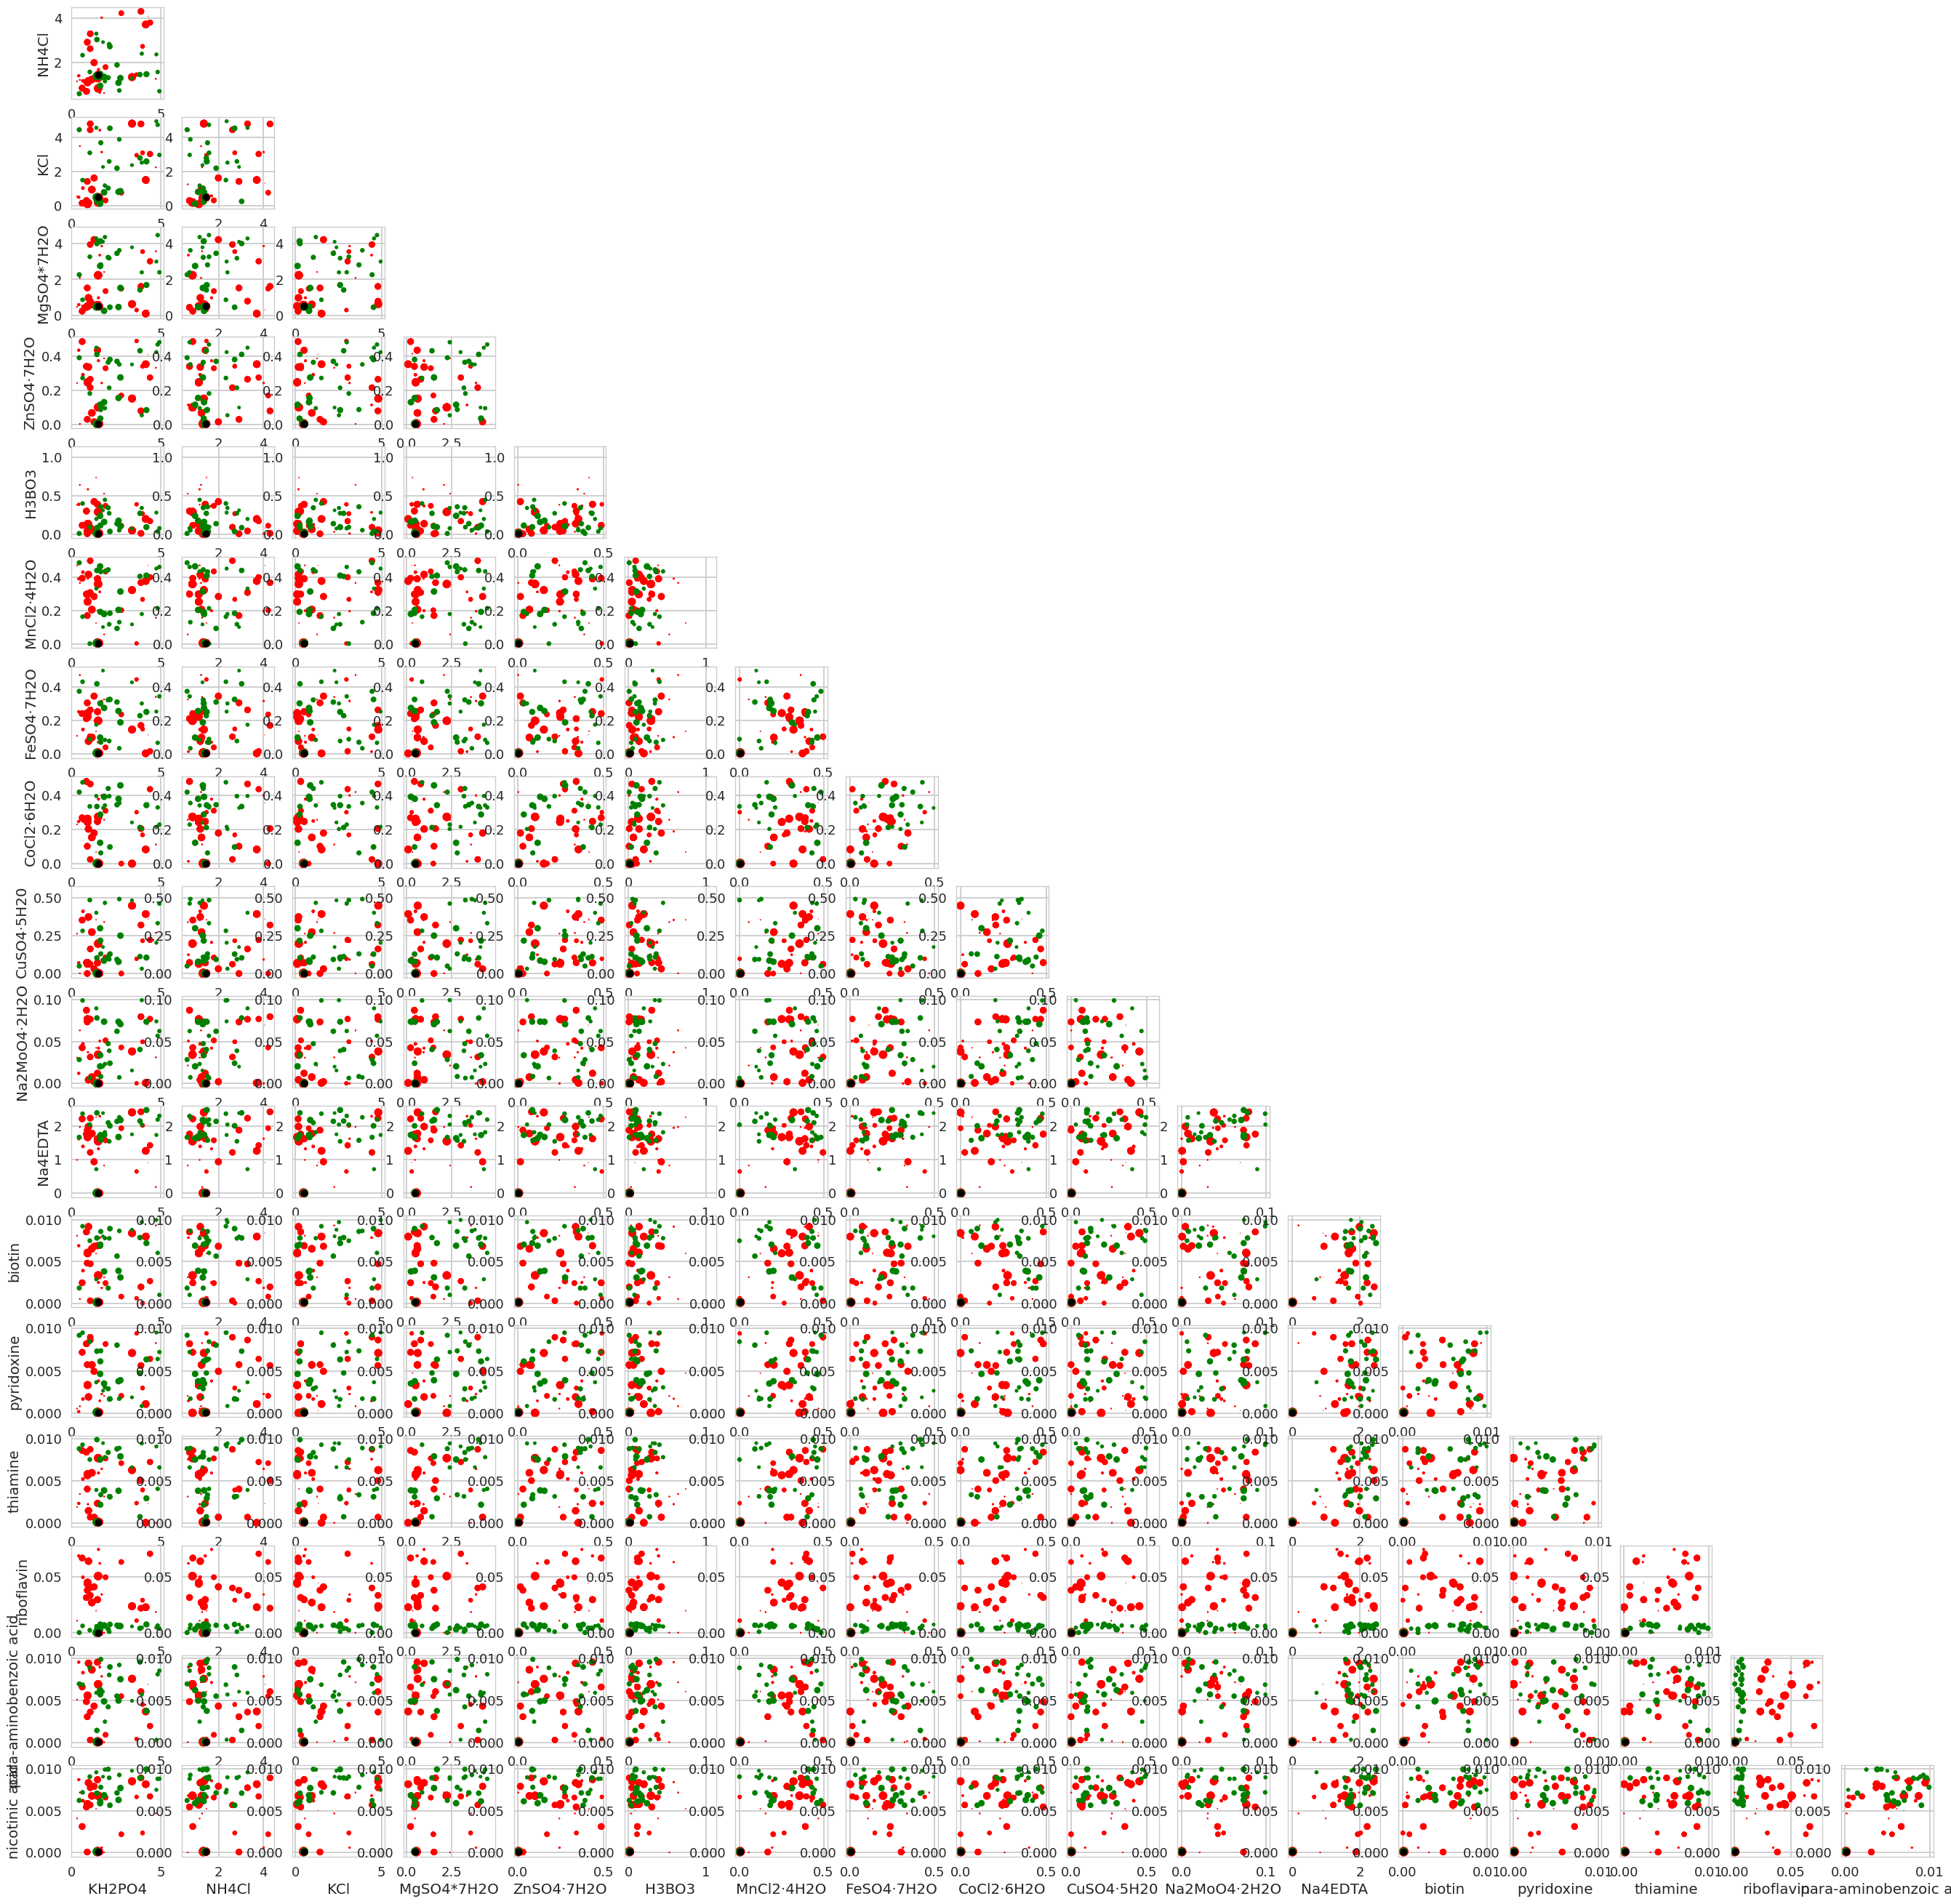

In [73]:
designs_pairwise(art, df_rec, user_params, df_stand,df_train)

In [74]:
df_rec

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (%),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,1.82367,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
1,2.738248,1.284099,0.860273,1.528955,0.275753,0.101989,0.312674,0.187852,0.458098,0.251518,...,0.003084,0.003881,0.007919,0.005949,0.007533,0.007714,0.602584,0.602584,0.241066,exploitation
2,2.63182,1.069462,0.820505,0.458457,0.155002,0.174604,0.203008,0.255577,0.379339,0.078182,...,0.003879,0.003764,0.003826,0.005992,0.004998,0.006287,0.595918,0.595918,0.239930,exploitation
3,1.601206,0.934964,0.12614,2.760471,0.115067,0.237814,0.462673,0.09742,0.122349,0.300567,...,0.006886,0.00463,0.007549,0.003106,0.006238,0.005901,0.592427,0.592427,0.239979,exploitation
4,1.612011,1.323856,0.242405,4.147066,0.03397,0.112,0.191472,0.301372,0.287936,0.218239,...,0.007021,0.00611,0.00217,0.007353,0.005734,0.00613,0.533017,0.533017,0.239322,exploitation
5,4.19672,1.461668,2.594845,1.692926,0.083325,0.091454,0.408242,0.250229,0.342213,0.106064,...,0.007193,0.006335,0.002926,0.007422,0.003771,0.009951,0.526519,0.526519,0.240645,exploitation
6,2.148154,2.720261,4.529747,0.448976,0.381521,0.034277,0.18323,0.32469,0.097828,0.129063,...,0.008927,0.001679,0.003107,0.007414,0.008987,0.005651,0.433369,0.433369,0.239502,exploitation
7,1.419173,3.038508,0.264294,4.016113,0.411739,0.084393,0.438187,0.418037,0.33458,0.104072,...,0.007804,0.007313,0.009914,0.003982,0.001454,0.007099,0.409223,0.409223,0.242281,exploitation
8,2.546857,1.882733,2.20075,3.467932,0.370727,0.135899,0.092613,0.309052,0.344832,0.093774,...,0.005636,0.008028,0.008808,0.006692,0.005526,0.007138,0.397457,0.397457,0.239780,exploitation
9,0.429504,0.572796,4.446868,2.269822,0.392297,0.008179,0.484359,0.373143,0.418843,0.049938,...,0.001815,0.009191,0.008835,0.000142,0.006977,0.00623,0.336897,0.336897,0.239955,exploitation



## Saving the generated designs

include all replicates:

In [75]:

df_rec_wells = df_rec.loc[df_rec.index.repeat(3)]

In [76]:
df_rec_wells

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (%),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,1.82367,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
0,1.82367,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
0,1.82367,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
1,2.738248,1.284099,0.860273,1.528955,0.275753,0.101989,0.312674,0.187852,0.458098,0.251518,...,0.003084,0.003881,0.007919,0.005949,0.007533,0.007714,0.602584,0.602584,0.241066,exploitation
1,2.738248,1.284099,0.860273,1.528955,0.275753,0.101989,0.312674,0.187852,0.458098,0.251518,...,0.003084,0.003881,0.007919,0.005949,0.007533,0.007714,0.602584,0.602584,0.241066,exploitation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,1.386331,3.304444,4.558025,4.301769,0.451285,0.196781,0.330133,0.17387,0.395969,0.40299,...,0.002865,0.003648,0.003917,0.005956,0.005919,0.009599,0.187565,0.187565,0.239173,exploration
24,1.386331,3.304444,4.558025,4.301769,0.451285,0.196781,0.330133,0.17387,0.395969,0.40299,...,0.002865,0.003648,0.003917,0.005956,0.005919,0.009599,0.187565,0.187565,0.239173,exploration
25,1.401804,1.37094,0.508727,0.475226,0.002299,0.011808,0.004561,0.005097,0.001738,0.001756,...,0.000108,0.000093,0.000095,0.000108,0.000109,0.000107,NaN,1.033674,0.237463,standard
25,1.401804,1.37094,0.508727,0.475226,0.002299,0.011808,0.004561,0.005097,0.001738,0.001756,...,0.000108,0.000093,0.000095,0.000108,0.000109,0.000107,NaN,1.033674,0.237463,standard




Rename index to well names:


In [77]:
well_rows = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
well_columns = '123'


In [78]:
well_names = [f'{row}{column}'  for row in well_rows for column in well_columns ]

df_rec_wells['Well'] = well_names
df_rec_wells = df_rec_wells.set_index(['Well'])
df_rec_wells


,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (%),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
Well,,,,,,,,,,,,,,,,,,,,,
A1,1.82367,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
A2,1.82367,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
A3,1.82367,1.339245,0.790969,0.246201,0.129921,0.158282,0.178631,0.273978,0.391274,0.085977,...,0.003804,0.003494,0.003872,0.006521,0.004902,0.006848,0.608169,0.608169,0.239658,exploitation
B1,2.738248,1.284099,0.860273,1.528955,0.275753,0.101989,0.312674,0.187852,0.458098,0.251518,...,0.003084,0.003881,0.007919,0.005949,0.007533,0.007714,0.602584,0.602584,0.241066,exploitation
B2,2.738248,1.284099,0.860273,1.528955,0.275753,0.101989,0.312674,0.187852,0.458098,0.251518,...,0.003084,0.003881,0.007919,0.005949,0.007533,0.007714,0.602584,0.602584,0.241066,exploitation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y2,1.386331,3.304444,4.558025,4.301769,0.451285,0.196781,0.330133,0.17387,0.395969,0.40299,...,0.002865,0.003648,0.003917,0.005956,0.005919,0.009599,0.187565,0.187565,0.239173,exploration
Y3,1.386331,3.304444,4.558025,4.301769,0.451285,0.196781,0.330133,0.17387,0.395969,0.40299,...,0.002865,0.003648,0.003917,0.005956,0.005919,0.009599,0.187565,0.187565,0.239173,exploration
Z1,1.401804,1.37094,0.508727,0.475226,0.002299,0.011808,0.004561,0.005097,0.001738,0.001756,...,0.000108,0.000093,0.000095,0.000108,0.000109,0.000107,NaN,1.033674,0.237463,standard


In [79]:
file = f"{user_params['output_file_path']}/target_concentrations_26.csv"
df_rec.to_csv(file) # This file will be used for the computation of volume transfers and data analysis
file = f"{user_params['output_file_path']}/target_concentrations_wells_26.csv"

df_rec_wells.to_csv(file) # This file will be used for the computation of volume transfers and data analysis
